### #import thư viện cần thiết

In [124]:
import re# thư viện để python làm việc với biểu thức chính quy
import csv# thư viện để xử lí file .csv
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer# thư viện để tokenize
from pyvi import ViUtils 

### # ghi dữ liệu sang một file mới
### # loại bỏ stopword, kí tự, viết hoa
### # kiểm tra xem có comment hoặc label nào bị trống không

In [ ]:
# đọc dữ liệu từ file gốc và sau đó loại bỏ stopwords và lưu lại vào file ra
input_file_path = 'review_update.csv'  # File CSV cần xử lý
output_file_path = 'data.csv'       # File CSV đầu ra
# Hàm đọc danh sách stopwords từ file
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())  # Đọc từng dòng và lưu vào set
    return stopwords
# Lấy danh sách stopwords từ file
stopwords = load_stopwords('vietnamese_stopwords.txt')
# Hàm làm sạch văn bản
def clean_text(text):
    # Chuyển tất cả chữ về dạng viết thường
    text = text.lower()
    # Loại bỏ emoji, ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^\w\sáàạảãạăắằặẳẵâấầậẩẫéèẹẻẽêếềệểễíìịỉĩóòọỏõôốồộổỗơớờợởỡúùụủũưứừựửữýỳýỵỷỹđ]', '', text)
    # Loại bỏ stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text
# Đọc dữ liệu từ file CSV
try:
    with open(input_file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data1 = list(reader)  # Đọc toàn bộ dữ liệu từ file CSV
except FileNotFoundError:
    print(f"Không tìm thấy file: {input_file_path}")
    exit()
except csv.Error:
    print(f"Lỗi khi đọc file CSV: {input_file_path}")
    exit()
# Lọc và xử lý các mục comment, kiểm tra label và chỉ ghi lại những phần hợp lệ
processed_data1 = []
empty_rows = []  # Danh sách lưu dòng có dữ liệu trống
for index, item in enumerate(data1):
    comment = item.get('Comment', '').strip()
    label = item.get('Label', '').strip()
    # Kiểm tra dòng nào có dữ liệu bị trống
    if not comment or not label:
        empty_rows.append(index + 1)  # Lưu chỉ mục dòng (bắt đầu từ 1)
        continue
    # Xử lý comment
    cleaned_comment = clean_text(comment)
    processed_data1.append({'Comment': cleaned_comment, 'Label': label})
# Báo các dòng có dữ liệu bị trống
if empty_rows:
    print(f"Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': {empty_rows}")
# Ghi lại dữ liệu đã xử lý vào file CSV mới
try:
    with open(output_file_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['Comment', 'Label'])
        writer.writeheader()  # Ghi tiêu đề cột
        writer.writerows(processed_data1)  # Ghi dữ liệu
    print(f"Dữ liệu đã được ghi vào {output_file_path}")
except IOError:
    print(f"Không thể ghi dữ liệu vào file {output_file_path}")

In [ ]:
data = pd.read_csv('data.csv')
data.head()

### #Lọc comment và label

In [ ]:
st_data =pd.DataFrame({'Comment': data['Comment'],'Label': data['Label']})
st_data = st_data.dropna()
st_data = st_data.reset_index(drop=True)
st_data.head()

In [ ]:
import pandas as pd
def count_labels_in_csv(file_path, label_column):
    try:
        # Đọc file CSV
        data = pd.read_csv(file_path)
        # Kiểm tra cột label có tồn tại không
        if label_column not in data.columns:
            print(f"Cột '{label_column}' không tồn tại trong file CSV.")
            return
        # Đếm số lượng xuất hiện của mỗi nhãn
        label_counts = data[label_column].value_counts()
        # In kết quả
        print("Số lượng các nhãn trong cột '{}' là:".format(label_column))
        for label, count in label_counts.items():
            print(f"{label}: {count}")
    except FileNotFoundError:
        print("File không tồn tại. Vui lòng kiểm tra đường dẫn.")
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")
# Ví dụ sử dụng
file_path = "data.csv"  # Thay đường dẫn đến file CSV của bạn
label_column = "Label"  # Thay tên cột Label của bạn
count_labels_in_csv(file_path, label_column)


### # Tạo một bản sao không có dấu, tokenization & lưu tạm

In [129]:
input_comment = st_data['Comment'].values
input_label = st_data['Label'].values
label_dictionary ={'positive':2,'neutral':1,'negative':0}
input_pre =[]
label_accent =[]
for idx, dt in enumerate(input_comment):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))# phần này là phần đã loại bỏ dấu
    input_text_pre_accent =ViTokenizer.tokenize(input_text_pre)# tokenization cho văn bản có dấu
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)# tokenization cho văn bản đã loại bỏ dấu
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_accent.append(input_label[idx])
    label_accent.append(input_label[idx])

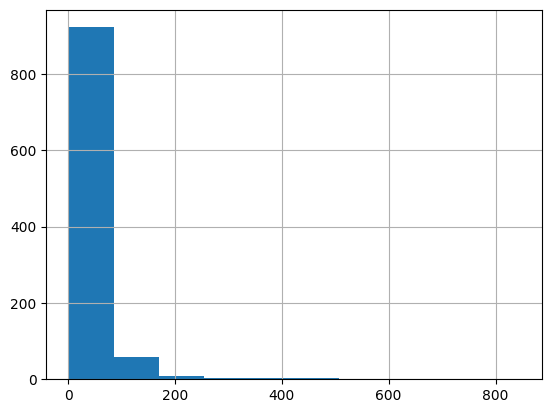

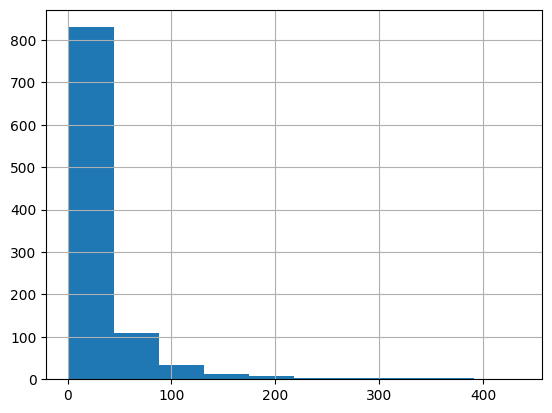

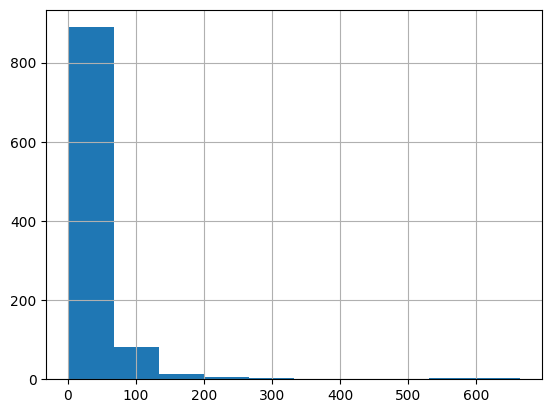

In [130]:
# lấy thông số và kiểm tra tần xuất
seq_len =[len(i.split())for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins =10)
plt.show()

In [131]:
file_path = 'data.csv' 
df = pd.read_csv(file_path)
# Kiểm tra xem cột 'Comment' có tồn tại trong file không
if 'Comment' in df.columns:
    # Đếm số từ trong mỗi bình luận
    df['word_count'] = df['Comment'].apply(lambda x: len(str(x).split()))  
    # Tìm bình luận có số từ nhiều nhất
    max_word_count_row = df.loc[df['word_count'].idxmax()]
    print(f"Bình luận có số từ nhiều nhất là ở dòng {max_word_count_row.name} với {max_word_count_row['word_count']} từ.")
    print(f"Đoạn bình luận: {max_word_count_row['Comment']}")
else:
    print("Không tìm thấy cột 'Comment' trong file CSV.")


Bình luận có số từ nhiều nhất là ở dòng 1386 với 865 từ.
Đoạn bình luận: có lẽ là câu chuyện quan điểm cá nhân mình ko đồng tình lắm với cách phân tích của bạn việt dương có kha khá khán giả thấy phim hay về câu chuyện đó có mìnhmình thấy phim có 1 câu chuyện rõ ràng có những cứ twist khiến khán giả thấy thú vị cách kể đủ sự lôi cuốn nhân vật linh dù giới thiệu qua đầu phim ta vẫn đủ hiểu linh là 1 mẫu thục nữ điển hình thời phong kiến xưa nhà nghèo có 1 cuộc tình đẹp từ bé mình ko nghĩ đó là sơ sài nó vừa đủ cho người xem hiểu bắt đầu cùng mạch truyện tìm hiểu khám phá nhân vật này thực sự càng xem mình càng thấy victor vũ khắc hoạ khai thác rất hay làm người xem ko bị shock thông lúc đầu từ từ tìm hiểu linh 1 cô gái hiền lành cam chịu khéo tay thương con có 1 tình yêu mãnh liệt nhân vật nhân cái này mình phải công nhận là hơi ít sự giới thiệu cũng câu chuyện 7 năm của nhân hơi qua loa với thời lượng của phim việc cân đối cho nhân bằng đó không gian là vừa đủ của đạo diễn 1 chàng hơi 

In [132]:
# chuyển đổi nhãn thành số và dạng one hot encoding
label_idx =[label_dictionary[i]for i in label_accent]
label_tf =tf.keras.utils.to_categorical(label_idx,num_classes=3)
# Tạo một tokenizer cho việc tách từ trong văn bản
tokenizer_data=Tokenizer(oov_token='<OOV>', split=' ')
# huấn luyện
tokenizer_data.fit_on_texts(input_pre)
# chuyển văn bản thành các chuỗi số
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
# Padding các chuỗi số, đảm bảo mỗi chuỗi có độ dài cố định (512 từ)
vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen=512)
# Lưu tokenizer đã huấn luyện vào file pickle để sử dụng sau này
pickle.dump(tokenizer_data,open("tokenizer_data.pkl", "wb"))
print("comment data.shape ",vec_data.shape)
data_voca_size =len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
#chia tệp dữ liệu thành bộ train và bộ validation 8-2
x_train, x_val,y_train,y_val= train_test_split(vec_data, label_tf,test_size=0.2,random_state=42)
#chia tệp dữ liệu thành bộ train và bộ test 9-1
x_train, x_test,y_train,y_test= train_test_split(vec_data, label_tf,test_size=0.1,random_state=42)
print("training sample: ",len(x_train))
print("validation sample: ",len(x_val))
print("test sample: ",len(x_test))

comment data.shape  (6460, 512)
data_voca_size:  6699
training sample:  5814
validation sample:  1292
test sample:  646


### # Build CNN +Bidirectional KSTM model for vietnamese language

In [133]:
def generate_model():# hàm chạy chính cho model kstm và cnn
    dropout_threshold =0.4
    input_dim =data_voca_size
    ouput_dim =32
    input_length = 512
    initializer= tf.keras.initializers.GlorotNormal()
    
    input_layer = Input(shape=(input_length,))
    feature =Embedding(input_dim=input_dim, output_dim=ouput_dim,input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)
    cnn_feature =Conv1D(filters=32, kernel_size=3, padding='same',activation='relu')(feature)
    cnn_feature =MaxPooling1D()(cnn_feature)
    cnn_feature =Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same',activation='relu')(cnn_feature)
    cnn_feature =MaxPooling1D()(cnn_feature)
    cnn_feature =LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    #bidirectional kstm
    bi_sktm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
    bi_sktm_feature = MaxPooling1D()(bi_sktm_feature)
    bi_sktm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(bi_sktm_feature)
    bi_sktm_feature = MaxPooling1D()(bi_sktm_feature)
    bi_sktm_feature = LayerNormalization()(bi_sktm_feature)
    combine_feature =tf.keras.layers.Concatenate()([cnn_feature,bi_sktm_feature])
    combine_feature =GlobalMaxPooling1D()(combine_feature)
    combine_feature =LayerNormalization()(combine_feature)
    Classifier =Dense(90, activation='relu')(combine_feature)
    Classifier =Dropout(0.2)(Classifier)
    Classifier =Dense(70, activation='relu')(Classifier)
    Classifier =Dropout(0.2)(Classifier)
    Classifier =Dense(50, activation='relu')(Classifier)
    Classifier =Dropout(0.2)(Classifier)
    Classifier =Dense(30, activation='relu')(Classifier)
    Classifier =Dropout(0.2)(Classifier)
    Classifier =Dense(3, activation='softmax')(Classifier)
    
    model= tf.keras.Model(inputs = input_layer, outputs =Classifier)
    return model
model =generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 512, 32)   │    214,368 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 512, 32)   │      3,104 │ embedding_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_56    │ (None, 256, 32)   │          0 │ conv1d_28[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 256, 32)   │          0 │ max_pooling1d_56… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_28    │ (None, 512, 64)   │     16,640 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 256, 32)   │      3,104 │ dropout_77[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_58    │ (None, 256, 64)   │          0 │ bidirectional_28… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_57    │ (None, 128, 32)   │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_29    │ (None, 256, 64)   │     18,816 │ max_pooling1d_58… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 32)   │         64 │ max_pooling1d_57… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_59    │ (None, 128, 64)   │          0 │ bidirectional_29… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 128, 32)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ max_pooling1d_59… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128, 96)   │          0 │ dropout_78[0][0], │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ concatenate_13[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,689 (1.06 MB)

 Trainable params: 276,689 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

### # Define model checkPoint & training

In [134]:
callback_model =tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss')
history =model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val),epochs=15, batch_size=64,callbacks=[callback_model])

Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - accuracy: 0.3336 - loss: 1.1246 - val_accuracy: 0.3584 - val_loss: 1.0986
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step - accuracy: 0.3481 - loss: 1.1013 - val_accuracy: 0.3584 - val_loss: 1.0960
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 324ms/step - accuracy: 0.3416 - loss: 1.0986 - val_accuracy: 0.3421 - val_loss: 1.0967
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 31s 338ms/step - accuracy: 0.3518 - loss: 1.0974 - val_accuracy: 0.3584 - val_loss: 1.0957
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 352ms/step - accuracy: 0.3466 - loss: 1.0971 - val_accuracy: 0.3584 - val_loss: 1.0966
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.3479 - loss: 1.0970 - val_accuracy: 0.3429 - val_loss: 1.0962
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 352ms/step - accuracy: 0.3567 - loss: 1.0959 - val_accuracy: 0.3506 - val_loss: 1.0954
Epoch 8/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 324ms/step - accuracy: 0.3477 - loss: 1.0984 - val_accu

### #model load on test data

In [135]:
model.load_weights("model.keras")
model.evaluate(x_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5547 - loss: 0.9924


[0.9509456753730774, 0.5820433497428894]

In [138]:
def preprocess_input(raw_input, tokenizer):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre =" ".join(input_text_pre)
    input_text_pre_accent= ViTokenizer.tokenize(input_text_pre)
    print("text preprocessed: ",input_text_pre_accent)
    tokenizer_data_text=tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen =512)
    return vec_data
def inference_model(input_feature,model):
    output=model(input_feature).numpy()[0]
    result =output.argmax()
    conf =float(output.max())
    label_dictionary={'negative':0,'neutral':1,'positive':2}
    label =list(label_dictionary.keys())
    return label[int(result)],conf
def prediction(raw_input, tokenizer,model):
    input_model=preprocess_input(raw_input,tokenizer_data)
    result,conf=inference_model(input_model,model)
    return result, conf
m_model= generate_model()
m_model=load_model('model.keras')
with open(r"tokenizer_data.pkl","rb")as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("phim gây thất vọng cho người xem",my_tokenizer,m_model))

text preprocessed:  phim gây thất_vọng cho người xem
('negative', 0.6750420928001404)


In [137]:
#while(True):
 #   text=input()
   # if text =="end":
   #     break
   # else:
    #    print(prediction(text,my_tokenizer,m_model)[0]+"\n")